In [24]:
path2train = "/home/e209440/data/train"
path2test = "/home/e209440/data/test"
#path2redux_data = "/home/r120084/project/data/redux/my_distract_driver_data_redux.npy"
path2redux_data = "/home/e209440/data/redux/my_distract_driver_data_redux.npy"

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, utils

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm 
import random

random.seed(7)

In [3]:
import os, glob, math,time
from scipy import misc

In [4]:
img_size = 50
sz = (img_size, img_size)

labels = {'c0' : 'safe driving', 
'c1' : 'texting - right', 
'c2' : 'talking on the phone - right', 
'c3' : 'texting - left', 
'c4' : 'talking on the phone - left', 
'c5' : 'operating the radio', 
'c6' : 'drinking', 
'c7' : 'reaching behind', 
'c8' : 'hair and makeup', 
'c9' : 'talking to passenger'}

#labels = {'c0' : 'safe driving', 'c1' : 'texting - right'}  #only if you want to load only few labels

few_samples = True
if few_samples:
    n_samples = 200

In [5]:
def process_image(img_file, sz):
    img = misc.imread(img_file)
    img = misc.imresize(img, sz).transpose((2,0,1)).astype('float32') / 255.0
    #img = img.transpose((2,0,1)).astype('float32') / 255.0
    return img

In [15]:
def load_traindata(path, labels, sz):
    print('Load train dataset...')
    X_train= []
    Y_train = []
    for j in tqdm(labels):
        path_folder = os.path.join(path, str(j), '*.jpg')
        files = glob.glob(path_folder)
        X_train.extend(process_image(im_file, sz) for im_file in files)
        Y_train.extend([int(j[-1])]*len(files))
        
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    return [X_train,Y_train]

In [16]:
path  = os.path.join(path2test, '*.jpg')
files = glob.glob(path)
len(files)

79726

In [17]:
def load_testdata(path,sz):
    print('Load test dataset...')
    X_test    = []
    
    path  = os.path.join(path2test, '*.jpg')
    files = glob.glob(path)
    
    X_test.extend(process_image(im_file,sz) for im_file in tqdm(files) )    
        
    X_test = np.array(X_test)
    
    return X_test

In [18]:
def get_driver_data(path2train, path2test, labels, sz):
    
    X_train, Y_train = load_traindata(path2train, labels, sz)
    X_test = load_testdata(path2test,sz)
    
    data = {}
    data['X_train'] = X_train
    data['Y_train'] = Y_train
    data['X_test'] = X_test
    return data

In [19]:
data = get_driver_data(path2train, path2test, labels, sz)

Load train dataset...



100%|██████████| 10/10 [03:29<00:00, 19.94s/it]


Load test dataset...



  2%|▏         | 1517/79726 [00:16<11:24, 114.24it/s]


  4%|▍         | 3324/79726 [00:32<10:59, 115.90it/s]


  6%|▋         | 5136/79726 [00:48<10:45, 115.50it/s]


  9%|▊         | 6948/79726 [01:04<10:31, 115.31it/s]


 11%|█         | 8760/79726 [01:20<10:14, 115.55it/s]


 13%|█▎        | 10552/79726 [01:35<09:53, 116.47it/s]


 15%|█▌        | 12328/79726 [01:51<09:47, 114.66it/s]


 18%|█▊        | 14088/79726 [02:06<09:41, 112.78it/s]


 20%|█▉        | 15682/79726 [02:23<09:15, 115.34it/s]


 22%|██▏       | 17464/79726 [02:39<09:04, 114.31it/s]


 24%|██▍       | 19213/79726 [02:55<15:53, 63.46it/s]


 26%|██▌       | 20697/79726 [03:11<09:24, 104.58it/s]


 28%|██▊       | 22359/79726 [03:27<08:14, 116.10it/s]


 30%|███       | 24105/79726 [03:43<08:55, 103.88it/s]


 32%|███▏      | 25553/79726 [03:59<11:15, 80.23it/s]


 34%|███▍      | 27100/79726 [04:15<15:02, 58.29it/s]


 36%|███▌      | 28678/79726 [04:31<07:58, 106.61it/s]


 38%|███▊      | 30306/79726 [04:46<07:43, 106.55it/s]


 40%|███▉      | 31743/79726 [05:02<07:36, 105.09it/s]


 42%|████▏     | 33362/79726 [05:18<07:15, 106.54it/s]


 44%|████▍     | 34990/79726 [05:34<07:07, 104.60it/s]


 46%|████▌     | 36618/79726 [05:49<06:45, 106.42it/s]


 48%|████▊     | 37914/79726 [06:05<11:51, 58.76it/s]


 49%|████▉     | 39354/79726 [06:22<06:21, 105.81it/s]


 51%|█████▏    | 40981/79726 [06:37<06:06, 105.66it/s]


 53%|█████▎    | 42507/79726 [06:53<05:49, 106.46it/s]


 55%|█████▌    | 44041/79726 [07:09<05:38, 105.45it/s]


 57%|█████▋    | 45542/79726 [07:25<10:53, 52.29it/s]


 59%|█████▉    | 46963/79726 [07:41<05:04, 107.43it/s]


 61%|██████    | 48591/79726 [07:56<04:49, 107.44it/s]


 63%|██████▎   | 50093/79726 [08:12<04:35, 107.64it/s]


 65%|██████▍   | 51617/79726 [08:28<05:02, 93.03it/s]


 66%|██████▋   | 53014/79726 [08:44<04:13, 105.47it/s]


 68%|██████▊   | 54310/79726 [09:01<04:03, 104.45it/s]


 70%|███████   | 55938/79726 [09:16<03:47, 104.57it/s]


 72%|███████▏  | 57485/79726 [09:32<03:29, 106.01it/s]


 74%|███████▍  | 58881/79726 [09:48<03:16, 106.11it/s]


 76%|███████▌  | 60389/79726 [10:04<03:11, 100.79it/s]


 78%|███████▊  | 62008/79726 [10:20<03:19, 88.80it/s]


 80%|███████▉  | 63534/79726 [10:37<04:49, 55.96it/s]


 82%|████████▏ | 65085/79726 [10:52<02:09, 113.36it/s]


 84%|████████▎ | 66742/79726 [11:08<01:52, 115.29it/s]


 86%|████████▌ | 68520/79726 [11:24<01:37, 115.33it/s]


 88%|████████▊ | 70110/79726 [11:40<02:39, 60.29it/s]


 90%|████████▉ | 71673/79726 [11:56<01:16, 104.77it/s]


 92%|█████████▏| 73051/79726 [12:13<01:02, 105.97it/s]


 93%|█████████▎| 74480/79726 [12:29<00:48, 107.11it/s]


 95%|█████████▌| 76108/79726 [12:44<00:34, 105.96it/s]


 98%|█████████▊| 77736/79726 [12:59<00:18, 107.42it/s]


 99%|█████████▉| 78982/79726 [13:16<00:07, 99.00it/s]


100%|██████████| 79726/79726 [13:23<00:00, 99.21it/s] 

In [20]:
def slice_data(data, n_samples):
    lst = np.arange(0,data.shape[0])
    lst_sample = random.sample(list(lst), n_samples)
    try:
        return data[lst_sample,:,:,:]
    except:
        return data[lst_sample]

In [22]:
n_samples = 250

data_redux ={}
if few_samples:
    data_redux['X_train'] = slice_data(data['X_train'], n_samples)
    data_redux['Y_train'] = slice_data(data['Y_train'], n_samples)
    data_redux['X_test'] = slice_data(data['X_test'], n_samples)
    #data1['X_test_id'] = slice_data(data['X_test_id'], n_samples)

In [26]:
# Save redux data
np.save(path2redux_data, data_redux) 

In [27]:
# Load redux data
read_dictionary = np.load(path2redux_data).item()

In [28]:
def plot_classes(labels, X, Y, img_size):
    #plt.figure(figsize=(20,10))
    size_subp= len(labels)
    cnt=1
    for i in labels:
        plt.figure()
        ix = random.randint(0, len(np.where(Y==str(i))[0]))
        ind = np.where(Y==int(i[-1]))[0][ix]
        image = X[ind].reshape(3,img_size,img_size).transpose((1,2,0))
        #plt.subplot(5,2, cnt)
        plt.imshow(image, cmap=plt.cm.gray_r)
        plt.axis('off')
        plt.title(labels[i])
        cnt +=1

/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


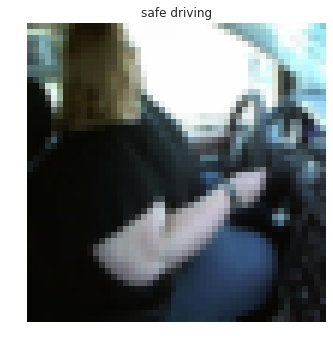

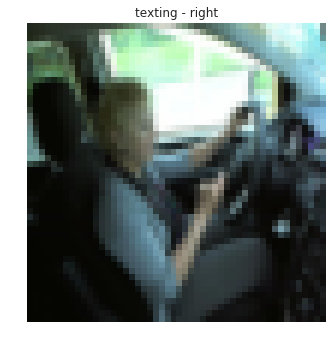

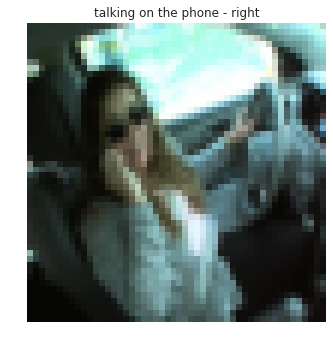

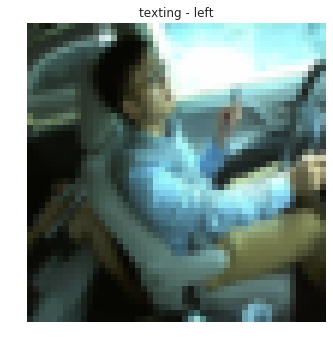

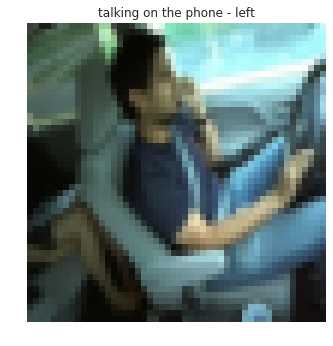

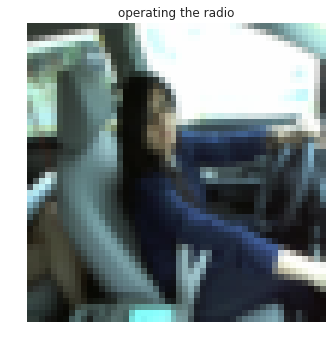

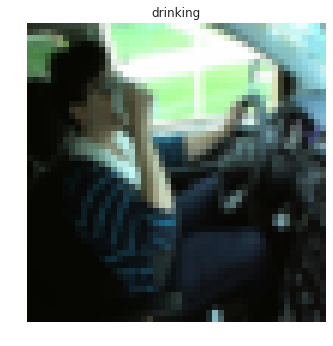

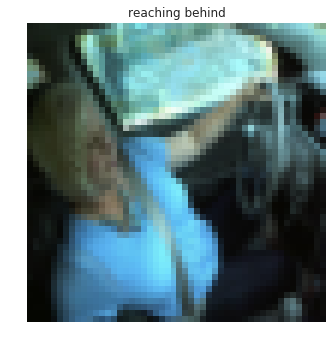

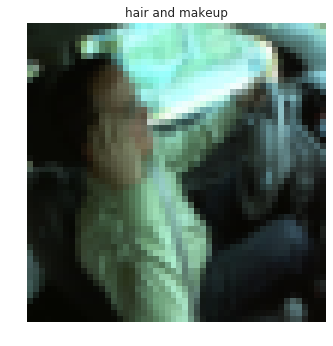

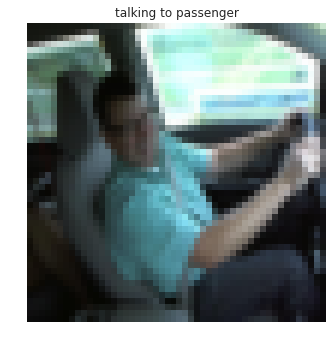

In [29]:
plot_classes(labels, data['X_train'], data['Y_train'], img_size)

In [30]:
# if you want to work with the redux data or not

redux = True

if redux:
    X_train = read_dictionary['X_train']
    Y_train = read_dictionary['Y_train']
    X_test = read_dictionary['X_test']
    
else:
    X_train = data['X_train']
    Y_train = data['Y_train']
    X_test = data['X_test']
    

## Convert to tensor

In [31]:
def array2tensor(X_train, Y_train, X_test):
        
    X_train_tns = tc.from_numpy(X_train).type(tc.FloatTensor)
    Y_train_tns = tc.from_numpy(Y_train).type(tc.FloatTensor)
    X_test_tns = tc.from_numpy(X_test).type(tc.FloatTensor)
    return [X_train_tns, Y_train_tns, X_test_id_tns]
    

In [ ]:
X_train_tns, Y_train_tns = array2tensor(X_train, Y_train,X_test)

In [ ]:
X_train_tns.shape, Y_train_tns.shape

In [ ]:
class CRDataset(Dataset):
    
    def __init__(self, data, target, transform):
        assert data.shape[0] == target.shape[0]
        
        self.data = data
        self.target = torch.LongTensor(target.astype(int))
        self.transform = transform
    
    def __len__(self):
        return self.target.shape[0]
    
    def __getitem__(self, i):
        data = self.transform(self.data[i, :, :, :])
        return (data, self.target[i])